In [1]:
# Librerias usadas
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar imagene
def show_image(img):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

## Primera Alternativa (Umbralización Simple) 

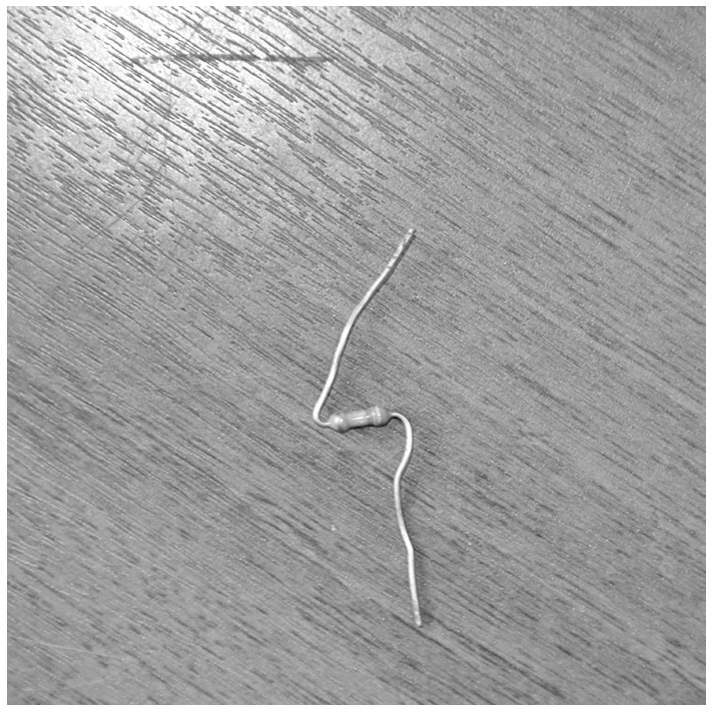

In [2]:
# Leer imagen en BGR
img = cv2.imread('test2.jpeg', 1)
# Convertir a HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# El canal v es el que contiene la información de la madera
v = img_hsv[:, :, 2]
# Mostrar imagen
show_image(v)

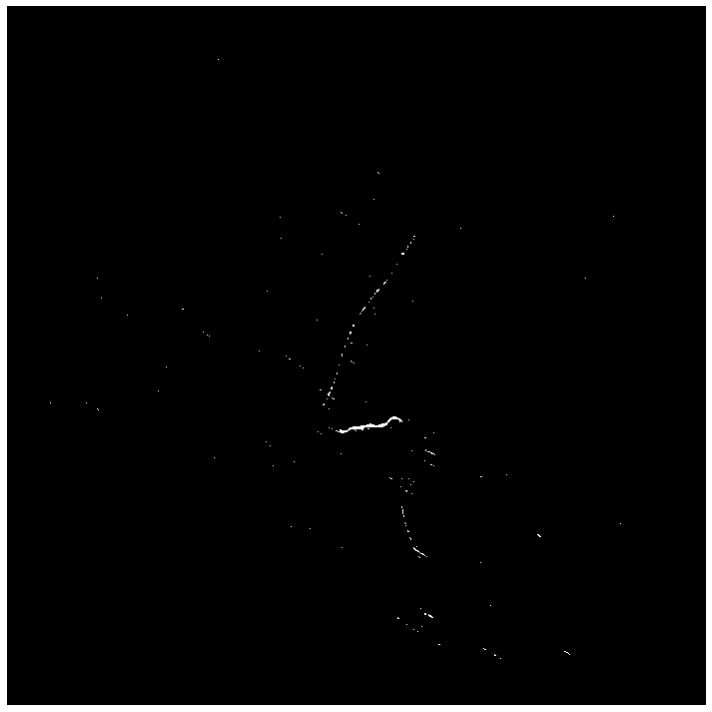

In [3]:
# Aplicar umbral, el valor puede variar dependiendo de la imagen, pero en este caso agarro un valor donde vean ruido, para que luego puedan lidear con eso

_, thresh = cv2.threshold(v, 90, 255, cv2.THRESH_BINARY_INV)

show_image(thresh)

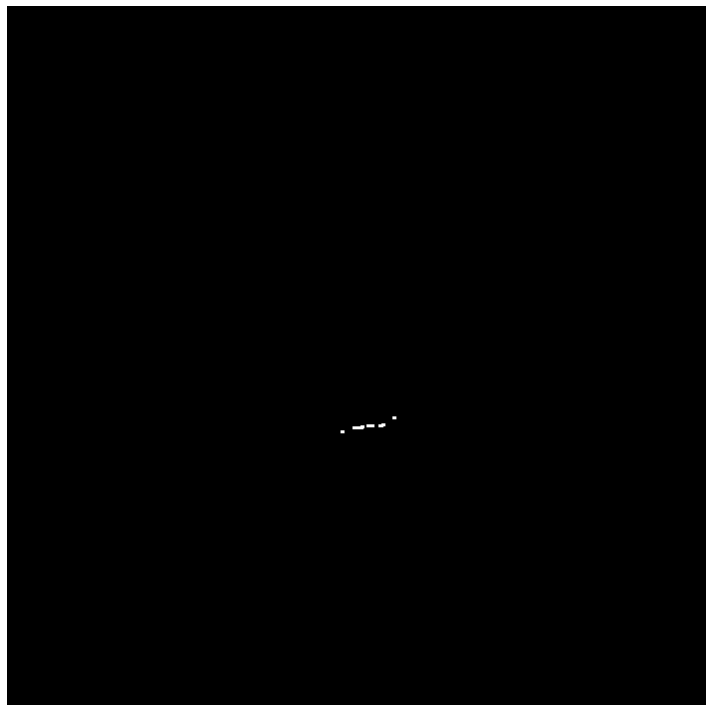

In [4]:
### Aquí vamos a lidiar con el ruido, hay muchas formas de hacerlo (Puede ser con filtros, o con operaciones morfológicas)

# Aproximación con operaciones morfológicas

# Crear kernel
kernel = np.ones((3, 3), np.uint8)

# Aplicar operación de apertura
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

show_image(opening)



Pareciera que se perdiera información... Pero recuerden que ustedes al principio de su proyecto decidieron trabajar con imagenes en ambientes ideales y semideales, de cierta manera esto les permite tener un ambiente controlado. Por lo tanto... Que pasá si hacemos un bounding box aproximado?

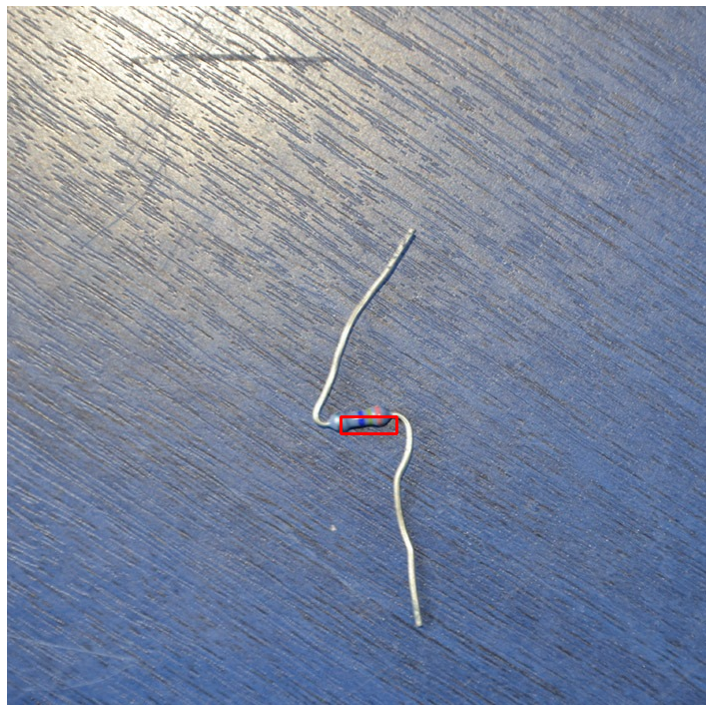

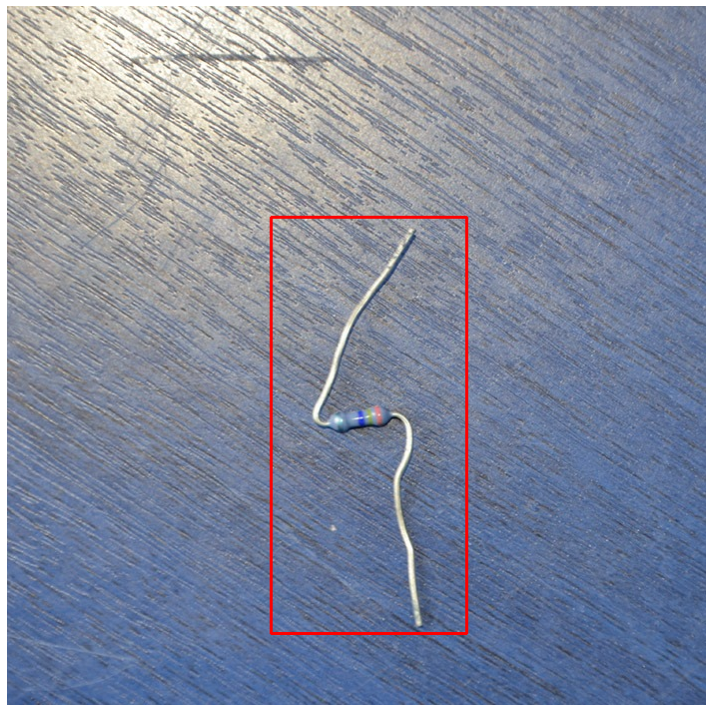

In [5]:
# Veamoslo acá

# Encuentra los contornos
contornos, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Inicializa las listas que contendrán los límites de los contornos
x_min = []
y_min = []
x_max = []
y_max = []

# Itera sobre los contornos y encuentra los límites
for cnt in contornos:
    x, y, w, h = cv2.boundingRect(cnt)
    x_min.append(x)
    y_min.append(y)
    x_max.append(x+w)
    y_max.append(y+h)

# Determina los límites generales
x1 = min(x_min)
y1 = min(y_min)
x2 = max(x_max)
y2 = max(y_max)

# Calcula el centro del bounding box
centro_x = x1 + (x2 - x1) // 2
centro_y = y1 + (y2 - y1) // 2

# Copia de la imagen original
copia = img.copy()
# Dibuja el bounding box en la imagen
cv2.rectangle(copia, (x1, y1), (x2, y2), (255,0,0), 2)

show_image(copia)

# Van a observar que no agarró lo que nos interesa, pero repito que pasa si teniendo el centro de donde puede estar nuestro objeto, ajustamos el boundind box?

x1 = x1 - 70
y1 = y1 - 200
x2 = x2 + 70
y2 = y2 + 200

# Copia de la imagen original
copia = img.copy()

# Dibuja el bounding box en la imagen
cv2.rectangle(copia, (x1, y1), (x2, y2), (255,0,0), 2)

show_image(copia)

Puede que se pregunten en este punto, "ah pero la madera sigue ahiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii" vean esto ahora

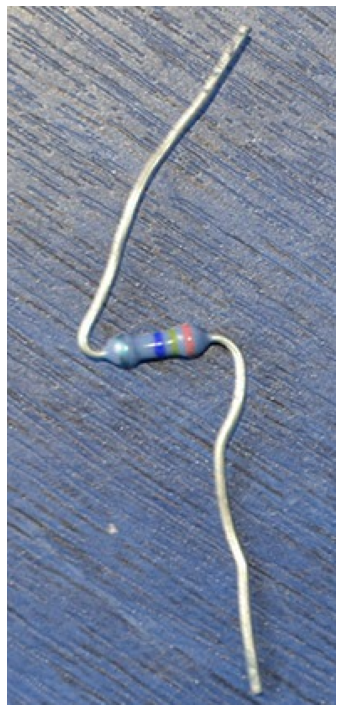

In [6]:
# copia de la imagen original

copia = img.copy()

# Recorta la imagen
recorte = copia[y1:y2, x1:x2]

show_image(recorte)

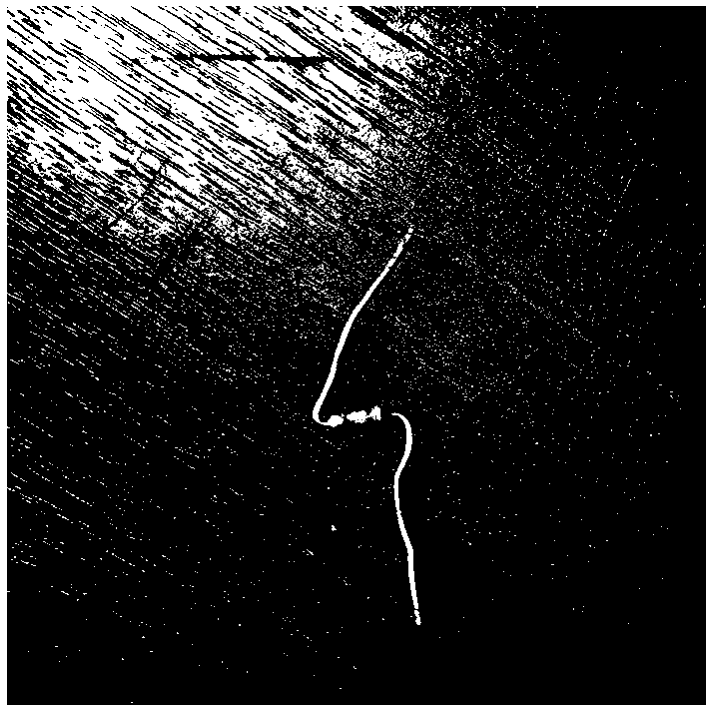

In [7]:
# Hay un threshold que es muy bueno para lidiar cuando hay diferentes tonalidades de madera, se llama Otsu, y es un threshold adaptativo, que se ajusta a la imagen
# uso toda la imagen, porque el se basa en el histograma de la imagen

_, thresh = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Ojo que el 0 es el valor que se usa para el threshold, pero en este caso no importa porque se usa el Otsu, son parametros que hay que pasarle a la función
# Recuerden otsu es un threshold adaptativo, que se ajusta a la imagen, es decir calcula el threshold que mejor se ajusta a la imagen automaticamente
show_image(thresh)

Aparentemente muy ruidoso... Pero, hey les tengo la solución: pre procesamiento, el ruido que ven ahí es el muy conocido ruido pimienta. Y hay filtros de convolución que lidin con eso, veamoslo!

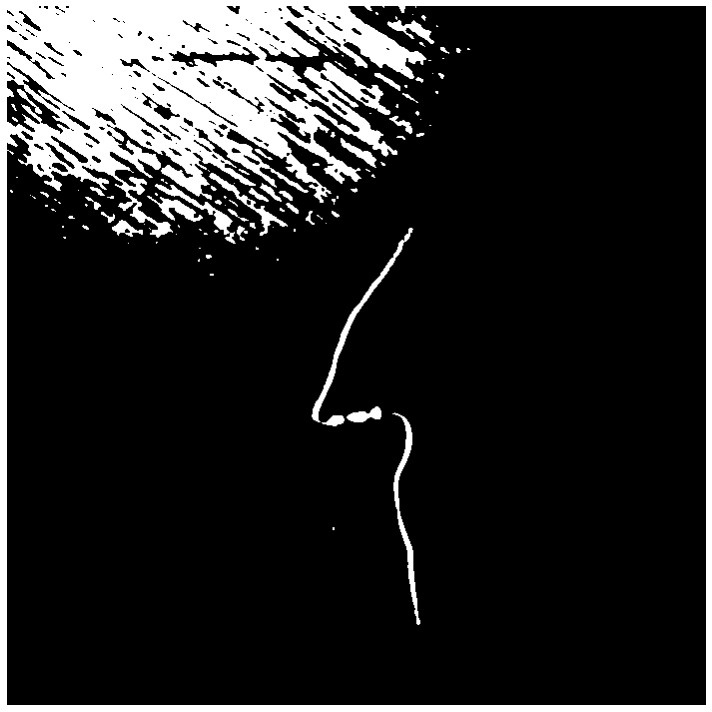

In [8]:
# Filtro gaussiano para suavizar la imagen
blur = cv2.GaussianBlur(v, (7, 7), 0)

# Aplicar threshold Otsu
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

show_image(thresh)

Depronto viendo esto, muy posiblemente pensarán, por qué carajos hicimos lo anterior (Extracción del recorte) y por qué no nos fuimos directamente acá? 
<br>
Rt: Si, se podían ir desde acá, pero aquí es donde les digo la segunda alternativa, ya tocarían jugar mas con operaciones morfologicas, lidiar con el ruido y generalizar porque claramente puede,
que la iluminación cambie, mientras que donde hicimos el recorte lidiamos con la iluminación directamente por lo que nos ofrece el canal 

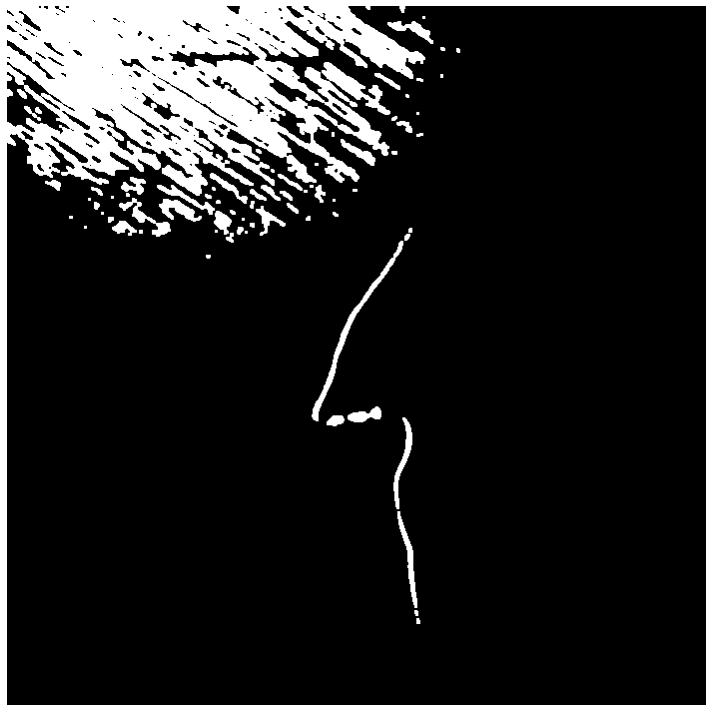

In [9]:
# antes de seguir, mejoremos el threshold, porque hay ruido, y eso puede afectar el resultado final

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

show_image(opening)

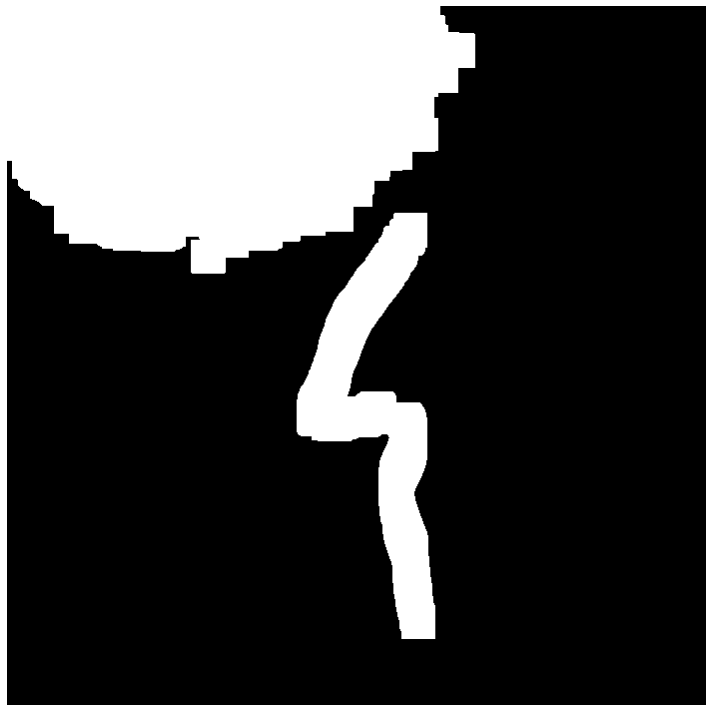

In [10]:
### dilatación

# Crear kernel
kernel = np.ones((3, 3), np.uint8)

# Aplicar dilatación

dilation = cv2.dilate(opening, kernel, iterations=15)

show_image(dilation)

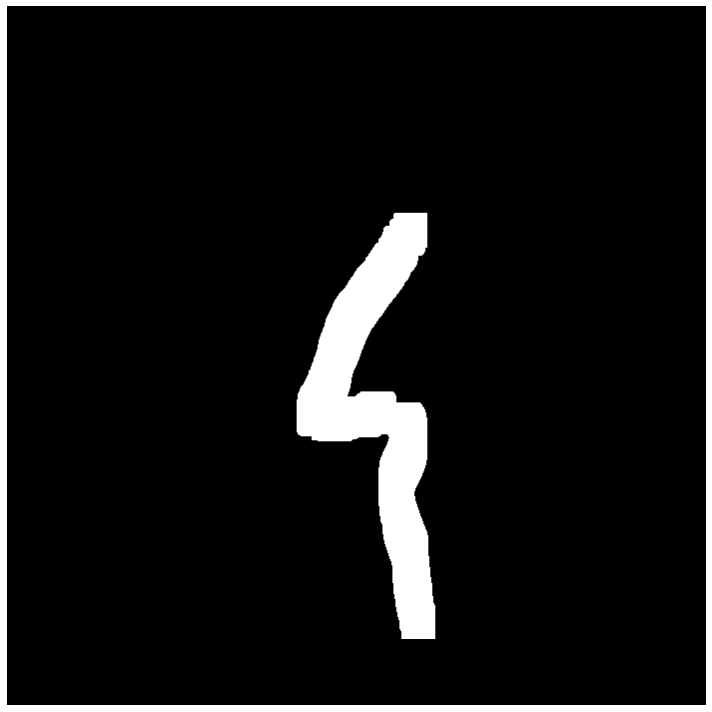

In [11]:
### Remover el contorno con mayor área

# Encuentra los contornos
contornos, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# elimino el contorno con mayor área o que se encuentre en un rango de área

for cnt in contornos:
    area = cv2.contourArea(cnt)
    if area >= 50000:
        cv2.drawContours(dilation, [cnt], 0, 0, -1)

show_image(dilation)


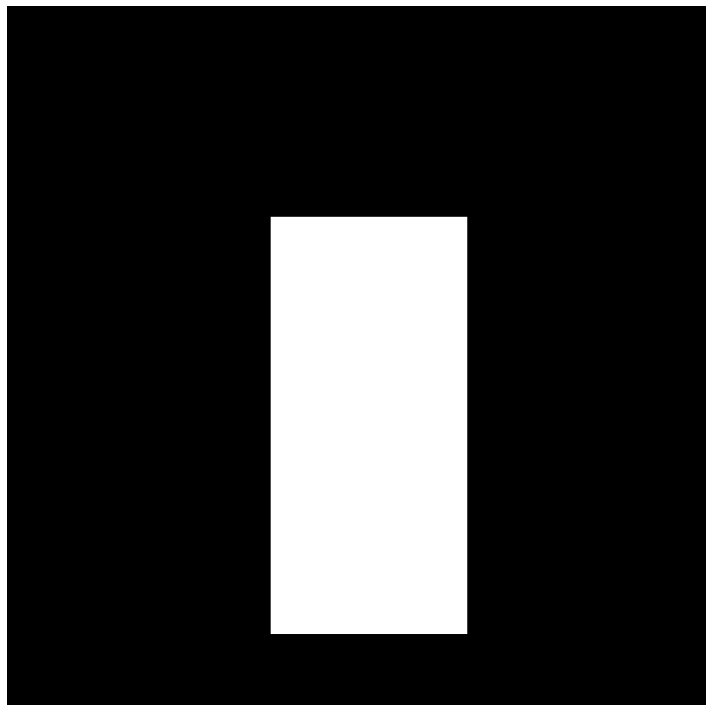

In [12]:
# Usemos transformaciones logicas para mejorar el resultado

# Para eso creemos una mascara a partir del bounding box

# Crear una imagen negra

mask = np.zeros_like(opening)

# Dibujar el bounding box en la mascara

cv2.rectangle(mask, (x1, y1), (x2, y2), (255,255,255), -1)

show_image(mask)


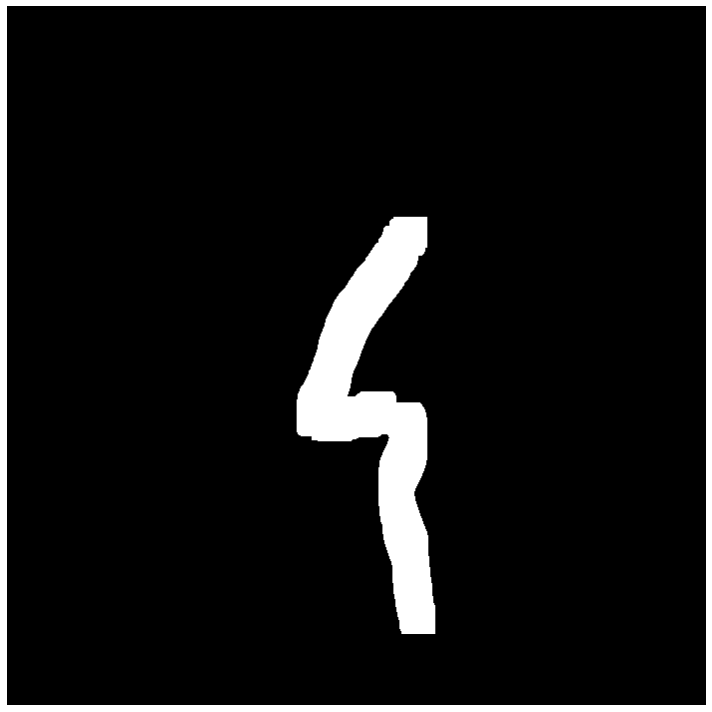

In [13]:
# Ya estamos terminando...

# Aplicar la mascara a la imagen

masked = cv2.bitwise_and(dilation, mask)

show_image(masked)

# Y, finalmente...

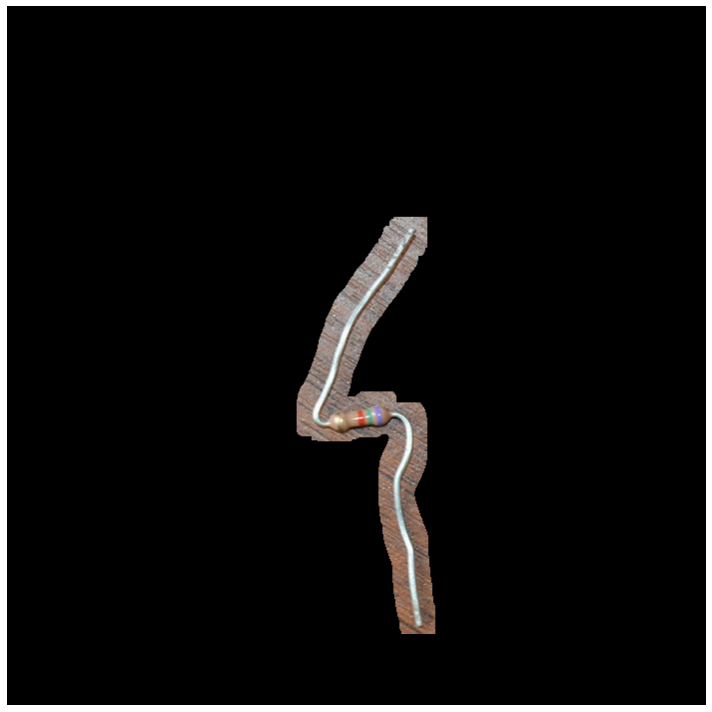

In [18]:
# Aplicar la mascara a la imagen original
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masked_rgb = cv2.bitwise_and(img_rgb, masked)

show_image(masked_rgb)

# Se puede mejorar? Sii, pero ya toca jugar muchooo con las operaciones anteriores.

## Segunda Alternativa (Otsu)

Ya se las comenté anteriormente, puede que sea algo mas simplificado, pero toca que hagan pruebas y ajustes para tener los mejores resultados!